In [1]:
# --- Section 1: Setup ---

import os
import pandas as pd
import numpy as np
from PIL import Image
from dotenv import load_dotenv
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    cohen_kappa_score,
    log_loss,
    classification_report,
    confusion_matrix
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

# For the NT-Xent Loss
# Make sure to install lightly: pip install lightly
from lightly.loss import NTXentLoss as MyContrastiveLoss

# Device Configuration
if torch.cuda.is_available():
    torch.cuda.empty_cache() # Add this line
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

# Environment and Path Configuration
load_dotenv()
BASE_DIR = os.getenv('FILE_PATH')
if not BASE_DIR:
    raise ValueError("FILE_PATH environment variable not set. Please create a .env file and set it.")

DATA_PATH = os.path.join(BASE_DIR, 'Full_preprocessed_detailed_house.csv')
PRETRAINING_DATA_PATH = os.path.join(BASE_DIR, 'Preprocessed_pretraining_set.csv')
print(f"Base Directory: {BASE_DIR}")
print(f"Data CSV Path: {DATA_PATH}")



Using device: cuda
Base Directory: ../../../Samsung_USB/
Data CSV Path: ../../../Samsung_USB/Full_preprocessed_detailed_house.csv


In [2]:
# --- Section 2: Data Ingestion ---

df = pd.read_csv(DATA_PATH)

merge_map = {
    'Bovenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Benedenwoning': 'Bovenwoning/Benedenwoning/Maisonette',
    'Maisonnette': 'Bovenwoning/Benedenwoning/Maisonette',
    'Corridorflat': 'Corridorflat/Galerijflat',
    'Galerijflat': 'Corridorflat/Galerijflat',
    'Hoekwoning': 'Hoekwoning/Eindwoning',
    'Eindwoning': 'Hoekwoning/Eindwoning',
    'Portiekflat': 'Portiekflat/Portiekwoning',
    'Portiekwoning': 'Portiekflat/Portiekwoning'
    # etc.
}

df['woningtype'] = df['woningtype'].map(merge_map).fillna(df['woningtype'])

df_pretraining = pd.read_csv(PRETRAINING_DATA_PATH)

print("Successfully loaded data. Shape:", df.shape)



Successfully loaded data. Shape: (6595, 23)


In [3]:
# --- Section 3: Preprocessing and Splitting ---

def preprocess_tabular_data(train_df, val_df, test_df):
    """Scales numeric columns and one-hot encodes categorical columns."""
    numeric_cols = ['opp_pand', 'build_year']
    categorical_cols = ['build_type']
    
    # Scale numeric columns based on the training set
    scaler = StandardScaler()
    train_df[numeric_cols] = scaler.fit_transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])
    print("Numeric features scaled.")

    # One-hot encode categorical columns based on the training set
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoder.fit(train_df[categorical_cols])
    
    cat_encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

    def encode_and_merge(df, encoder):
        encoded_data = encoder.transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_data, columns=cat_encoded_cols, index=df.index)
        return pd.concat([df.drop(columns=categorical_cols), encoded_df], axis=1)

    train_df = encode_and_merge(train_df, encoder)
    val_df = encode_and_merge(val_df, encoder)
    test_df = encode_and_merge(test_df, encoder)
    print("Categorical features one-hot encoded.")
    
    return train_df, val_df, test_df, numeric_cols, cat_encoded_cols


def clean_and_convert_features(df, feature_list):
    """Ensures all specified feature columns are numeric, filling NaNs."""
    cleaned_df = df.copy()
    for feature in feature_list:
        if feature in cleaned_df.columns:
            # Convert to numeric, coercing errors to NaN
            cleaned_df[feature] = pd.to_numeric(cleaned_df[feature], errors='coerce')
            # Fill any resulting NaNs with 0 (or a more suitable value like the mean)
            if cleaned_df[feature].isnull().sum() > 0:
                cleaned_df[feature] = cleaned_df[feature].fillna(0)
            # Ensure final type is float32 for PyTorch
            cleaned_df[feature] = cleaned_df[feature].astype('float32')
    return cleaned_df

def prepare_final_data(df, base_path):
    """Adds the full image path and encodes the 'woningtype' label."""
    # Build full image path
    df['img_path'] = df['frontview_url'].apply(lambda x: os.path.join(base_path, x))
    return df

# 1. Split the original dataframe
print("Splitting data into train (60%), validation (20%), and test (20%)...")
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42, stratify=df['woningtype'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['woningtype'])

# 2. Preprocess tabular data (scaling and encoding)
train_df, val_df, test_df, numeric_cols, cat_encoded_cols = preprocess_tabular_data(train_df, val_df, test_df)

# 3. Define the full list of features for the model
tabular_features = numeric_cols + cat_encoded_cols
print(f"Total tabular features ({len(tabular_features)}): {tabular_features}")

# 4. Clean the dataframes to ensure all feature columns are numeric
print("Cleaning and converting features to numeric types...")
train_df = clean_and_convert_features(train_df, tabular_features)
val_df = clean_and_convert_features(val_df, tabular_features)
test_df = clean_and_convert_features(test_df, tabular_features)

# 5. Create image paths and encode labels
print("Preparing final data (image paths and labels)...")
train_df = prepare_final_data(train_df, BASE_DIR)
val_df = prepare_final_data(val_df, BASE_DIR)
test_df = prepare_final_data(test_df, BASE_DIR)

# Fit LabelEncoder on the full training 'woningtype' to create integer labels
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['woningtype'])
# Use the same encoder for validation and test sets
val_df['label'] = label_encoder.transform(val_df['woningtype'])
test_df['label'] = label_encoder.transform(test_df['woningtype'])

print(f"Train size: {len(train_df)} | Val size: {len(val_df)} | Test size: {len(test_df)}")
print(f"Number of classes: {len(label_encoder.classes_)}")



Splitting data into train (60%), validation (20%), and test (20%)...
Numeric features scaled.
Categorical features one-hot encoded.
Total tabular features (7): ['opp_pand', 'build_year', 'build_type_Appartement', 'build_type_Hoekwoning', 'build_type_Tussen of geschakelde woning', 'build_type_Tweeonder1kap', 'build_type_Vrijstaande woning']
Cleaning and converting features to numeric types...
Preparing final data (image paths and labels)...
Train size: 3957 | Val size: 1319 | Test size: 1319
Number of classes: 10


In [4]:
# --- Section 4: Dataset and DataLoader ---

class HousingDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.counter = 0

        self._remove_missing()

    def __len__(self):
        return len(self.df)

    def _remove_missing(self):
        to_drop = []
        for idx, row in self.df.iterrows():
            img_path = row.get('img_path', row.get('frontview_url', None))
            if img_path is None:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row: missing image path')
                continue
            try:
                # Only check if file exists, don't open image (faster, avoids PIL errors on valid images)
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File not found: {img_path}")
            except Exception as e:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row due to image load error: {e}')

        # Drop all invalid rows at once
        self.df = self.df.drop(index=to_drop).reset_index(drop=True)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row.get('img_path', row.get('frontview_url', None))
        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            label = torch.tensor(row['label'], dtype=torch.long)
            return img, label
        except Exception as e:
            # print(f"Error loading data at index {idx} (path: {img_path}). Skipping. Error: {e}")
            return self.__getitem__((idx + 1) % len(self))


class UnlabelledImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.counter = 0

        self._remove_missing()

    def __len__(self):
        return len(self.df)

    def _remove_missing(self):
        to_drop = []
        for idx, row in self.df.iterrows():
            img_path = row.get('img_path', row.get('frontview_url', None))
            if img_path is None:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row: missing image path')
                continue
            try:
                # Only check if file exists, don't open image (faster, avoids PIL errors on valid images)
                if not os.path.exists(img_path):
                    raise FileNotFoundError(f"File not found: {img_path}")
            except Exception as e:
                to_drop.append(idx)
                self.counter += 1
                print(f'Dropped {self.counter}th row due to image load error: {e}')

        # Drop all invalid rows at once
        self.df = self.df.drop(index=to_drop).reset_index(drop=True)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row['img_path']
        try:
            image = Image.open(img_path).convert('RGB')
            # For contrastive learning, we need two augmented views of the same image
            if self.transform:
                return self.transform(image), self.transform(image) # Return two augmented views
            return image, image
        except Exception as e:
            # print(f"Error loading unlabelled image at index {idx} (path: {img_path}). Skipping. Error: {e}")
            return self.__getitem__((idx + 1) % len(self))


# ImageNet normalization values, commonly used for pretrained models
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Transformations for self-supervised pretraining (more aggressive augmentations)
pretrain_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize # Use the ImageNet normalization
])

# Transformations for supervised fine-tuning (simpler augmentations or just resizing/normalization)
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected input size
    transforms.RandomHorizontalFlip(), # A common augmentation for classification
    transforms.ToTensor(),          # Convert to tensor [0,1]
    normalize                       # Normalize using ImageNet stats
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to expected input size
    transforms.ToTensor(),          # Convert to tensor [0,1]
    normalize                       # Normalize using ImageNet stats
])

# Initialize datasets (for fine-tuning)
train_dataset = HousingDataset(train_df, transform=train_transforms)
val_dataset = HousingDataset(val_df, transform=val_transforms)
test_dataset = HousingDataset(test_df, transform=val_transforms)

# Create DataLoaders
BATCH_SIZE = 16 # Adjusted for common GPU memory sizes, can be tuned
NUM_WORKERS = 0 if os.name == 'nt' else 2 # Set num_workers=0 on Windows or for debugging

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Datasets and DataLoaders created successfully for fine-tuning.")




Dropped 1th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000051031-funda.jpg
Dropped 2th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0983200000089957-funda-in-business.jpg
Dropped 3th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0928200000017245-funda.jpg
Dropped 4th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/02/0269200000005631-funda-in-business.jpg
Dropped 5th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0907200000015381-funda.jpg
Dropped 6th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0983200000019253-funda.jpg
Dropped 7th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0995200000807820-funda.jpg
Dropped 8th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0935200000058871-funda.jpg
Dropped 9th row 

In [5]:
# --- Section 5: Model Definition ---

# 1. Define the Pretraining Model (SimCLR-like Encoder with Projection Head)
class SimCLREncoder(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model # This will be your ResNet50

        # Replace the original FC layer if it exists (for pre-trained models)
        # We need the features *before* the classification head
        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity() # Remove the final classification layer

        # Add a projection head for contrastive learning
        # This head projects the learned representation to a lower-dimensional space
        # where the contrastive loss is applied.
        self.projection_head = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.ReLU(),
            nn.Linear(in_features, 128) # Output dimension for the embeddings
        )

    def forward(self, x):
        features = self.base_model(x)
        embeddings = self.projection_head(features)
        return embeddings

# 2. Define your Fine-tuning Classifier
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes, pretrained_backbone_path=None, freeze_all_but_head=True):
        super().__init__()
        self.base_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        if pretrained_backbone_path:
            print(f"Loading self-supervised pretrained weights from: {pretrained_backbone_path}")
            # Load state_dict carefully. If your saved model was just the base_model, this is fine.
            # If it was the SimCLREncoder, you'd need to extract base_model.state_dict().
            self.base_model.load_state_dict(torch.load(pretrained_backbone_path, map_location=device))
        else:
            print("Using ImageNet pretrained weights for fine-tuning.")

        # Freeze base model parameters initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        in_features = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Option to freeze all but head initially
        if freeze_all_but_head:
            print("Freezing all base model layers, only classifier head is trainable initially.")
        else:
            # Original unfreezing strategy (less ideal for small datasets)
            print("Unfreezing layer3 and layer4 from the start.")
            for param in self.base_model.layer4.parameters():
                param.requires_grad = True
            for param in self.base_model.layer3.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

# --- Self-supervised Pretraining Function ---
def run_pretraining(unlabelled_df, num_epochs=100, batch_size=64, learning_rate=1e-3, device='cuda', save_path="resnet50_pretrained_on_houses.pth"):
    print(f"Starting self-supervised pretraining on device: {device}")
    
    # Initialize ResNet50 backbone (start with ImageNet weights, then pretrain further)
    resnet_backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    # Instantiate the self-supervised encoder
    pretrain_model = SimCLREncoder(resnet_backbone).to(device)
    
    # Create DataLoader for unlabelled data
    # Use the train_df for unlabelled data in a real scenario, or a dedicated unlabelled dataset.
    # For this setup, we'll use train_df as the source of unlabelled images.
    unlabelled_dataset = UnlabelledImageDataset(df=unlabelled_df, transform=pretrain_transform)
    unlabelled_dataloader = DataLoader(unlabelled_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)

    # Optimizer
    optimizer = torch.optim.Adam(pretrain_model.parameters(), lr=learning_rate)
    
    # Contrastive Loss Function (NT-Xent)
    contrastive_loss_fn = MyContrastiveLoss(temperature=0.08)

    print(f"Pretraining for {num_epochs} epochs with batch size {batch_size}...")
    for epoch in range(num_epochs):
        total_loss = 0
        loop = tqdm(unlabelled_dataloader, desc=f"Pretrain Epoch {epoch+1}/{num_epochs}", leave=False)
        for img1, img2 in loop:
            img1 = img1.to(device)
            img2 = img2.to(device)

            optimizer.zero_grad()

            # Get embeddings from two augmented views
            z_i = pretrain_model(img1)
            z_j = pretrain_model(img2)

            # Calculate contrastive loss
            loss = contrastive_loss_fn(z_i, z_j)

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_loss = total_loss / len(unlabelled_dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Average Pretraining Loss: {avg_loss:.4f}")

    print("Pretraining complete!")
    
    # Save the pretrained backbone weights
    torch.save(pretrain_model.base_model.state_dict(), save_path)
    print(f"Pretrained ResNet50 backbone saved to {save_path}")
    
    return save_path



In [6]:
# --- Section 6: Training & Validation Functions ---

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0
    all_preds, all_labels = [], []

    loop = tqdm(dataloader, desc="Validating", leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            loop.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = accuracy_score(all_labels, all_preds)
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    return epoch_loss, epoch_acc, epoch_f1



In [7]:
# --- Section 7: Evaluation & Model Utilities ---

def evaluate_model(model, dataloader, device, class_names):
    """
    Evaluates the model on a given dataloader and prints a comprehensive report
    including individual metrics, a classification report, and a confusion matrix.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            # Get probabilities for log_loss
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            
            # Get predictions for other metrics
            preds = np.argmax(probs, axis=1)
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    # --- Calculate and Print Individual Metrics ---
    print("\n--- Evaluation Metrics ---")
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
    kappa = cohen_kappa_score(all_labels, all_preds)
    logloss = log_loss(all_labels, all_probs)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (macro): {precision:.4f}")
    print(f"Recall (macro): {recall:.4f}")
    print(f"F1 Score (macro): {f1:.4f}")
    print(f"Cohen's Kappa: {kappa:.4f}")
    print(f"Log Loss: {logloss:.4f}")

    # --- Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # --- Confusion Matrix ---
    print("\n--- Confusion Matrix ---")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



In [8]:
# --- Section 8: Pretraining ---

pretraining = True  # Set to True to run pretraining, False to skip

# Add 'img_path' column to df_pretraining if it does not exist
if 'img_path' not in df_pretraining.columns:
    df_pretraining['img_path'] = BASE_DIR + df_pretraining['frontview_url'].astype(str)

# Ensure a directory for saving models exists
os.makedirs("models", exist_ok=True)
pretrained_backbone_save_path = "models/resnet50_ssl_pretrained_backbone3.pth"

if pretraining == True:
    # --- Step 1: Self-supervised Pretraining ---
    print("\n" + "="*50)
    print("Starting Self-Supervised Pretraining Phase")
    print("="*50 + "\n")
    # You typically pretrain on your *unlabelled* data. Here, we'll use train_df as our unlabelled pool.
    # In a real scenario, this would be a much larger dataset of unlabelled images.
    pretrained_weights_file = run_pretraining(
        unlabelled_df=df_pretraining, # Use your dedicated pretraining set
        num_epochs=4,                # Adjust epochs for actual training
        batch_size=BATCH_SIZE,
        learning_rate=1e-5,           # Smaller learning rate for pretraining
        device=device,
        save_path=pretrained_backbone_save_path
    )




Starting Self-Supervised Pretraining Phase

Starting self-supervised pretraining on device: cuda
Dropped 1th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0944200000213446-funda.jpg
Dropped 2th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0984200000022544-funda.jpg
Dropped 3th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0983200000032760-funda.jpg
Dropped 4th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0944200000207939-funda.jpg
Dropped 5th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000038655-funda.jpg
Dropped 6th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000046370-funda.jpg
Dropped 7th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0971200000053838-funda.jpg
Dropped 8th row due to image load error: File not found: ../..

Epoch 1/4, Average Pretraining Loss: 0.4980


Epoch 2/4, Average Pretraining Loss: 0.1801


Epoch 3/4, Average Pretraining Loss: 0.1111


Epoch 4/4, Average Pretraining Loss: 0.0784
Pretraining complete!
Pretrained ResNet50 backbone saved to models/resnet50_ssl_pretrained_backbone3.pth


In [9]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

analysis_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

def analyze_pretrained_embeddings(pretrained_model_path, unlabelled_df, device, sample_size=1000):
    """
    Loads the pretrained model, extracts embeddings, and performs analysis (statistics, t-SNE).
    """
    print(f"\n--- Analyzing Pretrained Embeddings from: {pretrained_model_path} ---")

    # Initialize the base ResNet50 model
    resnet_backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # Instantiate the SimCLR encoder, which includes the projection head
    model = SimCLREncoder(resnet_backbone).to(device)

    # Load the state dict for the base_model (resnet_backbone)
    # The saved file 'resnet50_ssl_pretrained_backbone.pth' contains state_dict of `pretrain_model.base_model`
    # so we load it directly into `model.base_model`.
    try:
        model.base_model.load_state_dict(torch.load(pretrained_model_path, map_location=device))
        print("Pretrained backbone loaded successfully.")
    except Exception as e:
        print(f"Error loading pretrained model state dict: {e}")
        print("Please ensure the path is correct and the state_dict keys match the ResNet50 backbone.")
        return

    model.eval() # Set model to evaluation mode

    # Create DataLoader for a subset of unlabelled data for analysis
    # Limit the dataframe to a sample size for faster analysis
    if len(unlabelled_df) > sample_size:
        df_sample = unlabelled_df.sample(sample_size, random_state=42).reset_index(drop=True)
    else:
        df_sample = unlabelled_df.reset_index(drop=True)

    analysis_dataset = UnlabelledImageDataset(df=df_sample, transform=analysis_transform)
    # Use a larger batch size for inference if memory allows
    analysis_loader = DataLoader(analysis_dataset, batch_size=64, shuffle=False, num_workers=0) # num_workers=0 for simplicity

    all_embeddings = []
    print(f"Extracting embeddings for {len(analysis_dataset)} images...")
    with torch.no_grad():
        for images, _ in tqdm(analysis_loader, desc="Extracting Embeddings"):
            images = images.to(device)
            # Pass through the full SimCLR encoder to get the projected embeddings
            embeddings = model(images).cpu().numpy()
            all_embeddings.append(embeddings)

    all_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Extracted {len(all_embeddings)} embeddings of dimension {all_embeddings.shape[1]}.")

    # --- Statistical Analysis of Embeddings ---
    print("\n--- Embedding Statistics ---")
    print(f"Mean (across batch, per dimension): {np.mean(all_embeddings, axis=0)}")
    print(f"Standard Deviation (across batch, per dimension): {np.std(all_embeddings, axis=0)}")
    print(f"Variance (across batch, per dimension): {np.var(all_embeddings, axis=0)}")
    print(f"Min value (across all embeddings): {np.min(all_embeddings)}")
    print(f"Max value (across all embeddings): {np.max(all_embeddings)}")
    print(f"Overall Mean: {np.mean(all_embeddings):.4f}")
    print(f"Overall Std Dev: {np.std(all_embeddings):.4f}")
    print(f"Overall Variance: {np.var(all_embeddings):.4f}")

    if np.var(all_embeddings) < 1e-6: # Check for near-zero overall variance
        print("\nWARNING: Overall embedding variance is extremely low, which is a strong indicator of model collapse (all embeddings are nearly identical).")
    else:
        print("\nEmbedding variance appears healthy (not extremely low).")


    # --- Dimensionality Reduction and Visualization (t-SNE) ---
    print("\n--- Visualizing Embeddings with t-SNE ---")
    # First, use PCA for initial dimensionality reduction if embedding dimension is very high
    # This speeds up t-SNE for larger datasets
    if all_embeddings.shape[1] > 50: # Arbitrary threshold, adjust if needed
        print(f"Applying PCA to reduce dimensions from {all_embeddings.shape[1]} to 50 for t-SNE...")
        pca = PCA(n_components=50, random_state=42)
        embeddings_pca = pca.fit_transform(all_embeddings)
        embeddings_to_tsne = embeddings_pca
    else:
        embeddings_to_tsne = all_embeddings

    print("Running t-SNE...")
    # It's important to set a random_state for reproducibility
    # perplexity is a critical parameter, usually between 5 and 50
    # n_iter_without_progress helps determine convergence
    try:
        tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, n_iter_without_progress=300, learning_rate='auto', init='random')
        embeddings_2d = tsne.fit_transform(embeddings_to_tsne)

        plt.figure(figsize=(10, 8))
        sns.scatterplot(
            x=embeddings_2d[:, 0], y=embeddings_2d[:, 1],
            palette=sns.color_palette("hls", 1), # Use a single color since no labels
            legend="full",
            alpha=0.6
        )
        plt.title('t-SNE Visualization of Pretrained Image Embeddings (No Labels)')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
        print("t-SNE plot generated. A single, dense cluster indicates potential collapse.")
    except Exception as e:
        print(f"Error during t-SNE visualization: {e}")
        print("t-SNE might fail if all embeddings are identical (e.g., due to model collapse).")





--- Analyzing Pretrained Embeddings from: models/resnet50_ssl_pretrained_backbone3.pth ---


C:\Users\Matth\AppData\Local\Temp\ipykernel_28100\4237188218.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.base_model.load_state_dict(torch.load(pretrained_mode

Pretrained backbone loaded successfully.
Dropped 1th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0935200000066289-funda.jpg
Dropped 2th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0946200000219598-funda.jpg
Dropped 3th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0995200000806744-funda.jpg
Dropped 4th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0957200000026208-funda.jpg
Dropped 5th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0988200000032935-funda.jpg
Dropped 6th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0995200000765804-funda.jpg
Dropped 7th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0957200000004726-funda.jpg
Dropped 8th row due to image load error: File not found: ../../../Samsung_USB/img_dataset/09/0917200000023414-funda.jpg

Extracting Embeddings: 100%|██████████| 31/31 [01:14<00:00,  2.42s/it]
C:\Users\Matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Extracted 1975 embeddings of dimension 128.

--- Embedding Statistics ---
Mean (across batch, per dimension): [ 0.016868   -0.09678269  0.06043173 -0.0755939  -0.03468755 -0.00042376
  0.10183187  0.01304066 -0.05098163 -0.0068801   0.03158017 -0.04855282
  0.0645726   0.02736267  0.04387538  0.04657392  0.01890531 -0.02789224
 -0.03265669 -0.01124666  0.06173681 -0.02505185  0.0292938   0.03491685
 -0.07155447 -0.00782688  0.0410409  -0.09017616 -0.06226286  0.0321413
  0.01847954  0.05623248 -0.02097963 -0.00301344 -0.00915641  0.02278846
  0.00699942 -0.12891024  0.02025415 -0.01261857  0.01536967 -0.03777162
 -0.00281268 -0.05346196  0.01967132 -0.0278513   0.05071868 -0.03377913
  0.01136904 -0.01019693  0.0618955   0.02746995 -0.01628888 -0.06129741
  0.00309522 -0.04252761  0.01824015 -0.01387228 -0.00425311 -0.00949596
  0.00254689  0.02130472  0.03580415  0.01215478  0.00440122 -0.0570591
  0.00746034 -0.05749161  0.05730637 -0.04007335  0.04480194  0.01518789
 -0.00430667 -0.

C:\Users\Matth\AppData\Local\Temp\ipykernel_28100\4237188218.py:95: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


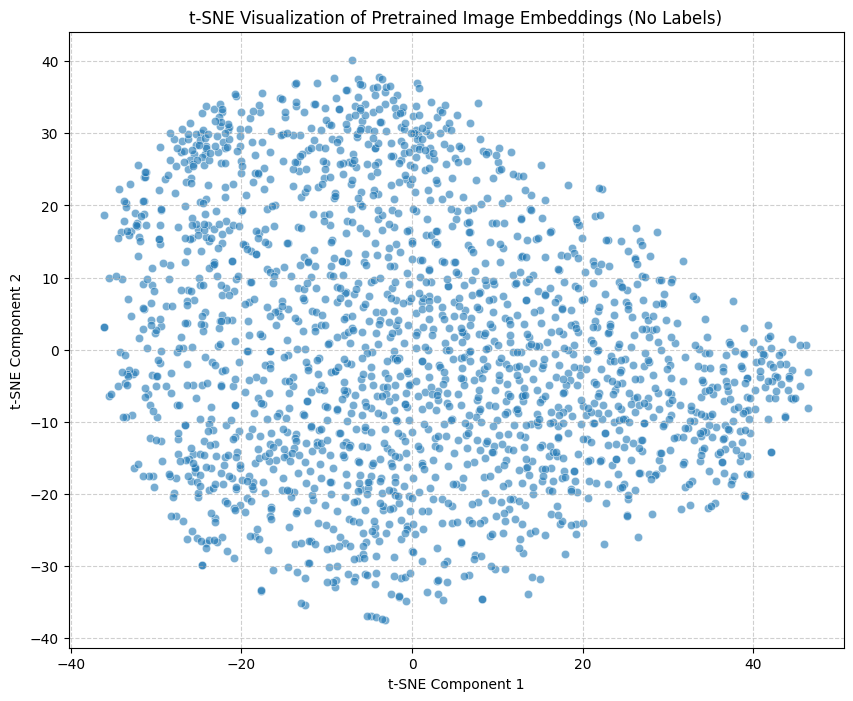

t-SNE plot generated. A single, dense cluster indicates potential collapse.


In [10]:
if pretraining == False:
    pretrained_backbone_save_path = "models/resnet50_ssl_pretrained_backbone3.pth"
else:
    pretrained_backbone_save_path = pretrained_weights_file

# Make sure the models directory exists
if not os.path.exists("models"):
    os.makedirs("models")
    print("Created 'models' directory.")

# Check if the pretrained model file exists before attempting to analyze
if not os.path.exists(pretrained_backbone_save_path):
    print(f"Error: Pretrained model file not found at {pretrained_backbone_save_path}")
    print("Please ensure the pretraining phase has completed successfully and saved the model.")
    print("You might need to run your original pretraining script first to generate the .pth file.")
else:
    analyze_pretrained_embeddings(
        pretrained_model_path=pretrained_backbone_save_path,
        unlabelled_df=df_pretraining,
        device=device,
        sample_size=2000 # Increase sample size if you have enough memory/time
    )



Starting Supervised Fine-tuning Phase

Using ImageNet pretrained weights for fine-tuning.
Freezing all base model layers, only classifier head is trainable initially.


C:\Users\Matth\AppData\Local\Temp\ipykernel_28100\3896630340.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone_state = torch.load(pretrained_weights_file, map_lo

Loaded backbone weights. Missing keys: [], Unexpected keys: []
Fine-tuning head for 3 epochs...

--- Fine-tuning Epoch 1/3 ---


Train Loss: 1.9642, Acc: 0.2870, F1: 0.2133
Val Loss: 1.7214, Acc: 0.3625, F1: 0.2936
Saved best model with Val F1: 0.2936

--- Fine-tuning Epoch 2/3 ---


Train Loss: 1.6749, Acc: 0.3728, F1: 0.3367
Val Loss: 1.6041, Acc: 0.4092, F1: 0.3703
Saved best model with Val F1: 0.3703

--- Fine-tuning Epoch 3/3 ---


Train Loss: 1.5825, Acc: 0.4124, F1: 0.3884
Val Loss: 1.5547, Acc: 0.4123, F1: 0.3855
Saved best model with Val F1: 0.3855
Fine-tuning layer3 & 4 for 9 epochs...

--- Fine-tuning Epoch 1/9 ---


Train Loss: 1.4976, Acc: 0.4408, F1: 0.4206
Val Loss: 1.5069, Acc: 0.4360, F1: 0.4133
Saved best model with Val F1: 0.4133

--- Fine-tuning Epoch 2/9 ---


Train Loss: 1.4320, Acc: 0.4650, F1: 0.4490
Val Loss: 1.4711, Acc: 0.4529, F1: 0.4335
Saved best model with Val F1: 0.4335

--- Fine-tuning Epoch 3/9 ---


Train Loss: 1.3347, Acc: 0.4957, F1: 0.4805
Val Loss: 1.4515, Acc: 0.4690, F1: 0.4537
Saved best model with Val F1: 0.4537

--- Fine-tuning Epoch 4/9 ---


Train Loss: 1.2501, Acc: 0.5414, F1: 0.5285
Val Loss: 1.4323, Acc: 0.4743, F1: 0.4592
Saved best model with Val F1: 0.4592

--- Fine-tuning Epoch 5/9 ---


Train Loss: 1.1781, Acc: 0.5572, F1: 0.5469
Val Loss: 1.4219, Acc: 0.4713, F1: 0.4588

--- Fine-tuning Epoch 6/9 ---


Train Loss: 1.0996, Acc: 0.5981, F1: 0.5888
Val Loss: 1.4267, Acc: 0.4728, F1: 0.4627
Saved best model with Val F1: 0.4627

--- Fine-tuning Epoch 7/9 ---


Train Loss: 1.0098, Acc: 0.6254, F1: 0.6163
Val Loss: 1.4220, Acc: 0.4843, F1: 0.4770
Saved best model with Val F1: 0.4770

--- Fine-tuning Epoch 8/9 ---


Train Loss: 0.9385, Acc: 0.6614, F1: 0.6555
Val Loss: 1.4429, Acc: 0.4743, F1: 0.4625

--- Fine-tuning Epoch 9/9 ---


C:\Users\Matth\AppData\Local\Temp\ipykernel_28100\3896630340.py:88: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/best_house_classif

Train Loss: 0.8422, Acc: 0.7043, F1: 0.6978
Val Loss: 1.4500, Acc: 0.4843, F1: 0.4740

Fine-tuning complete!

Evaluating Best Model on Test Set


--- Evaluation Metrics ---
Accuracy: 0.4654
Precision (macro): 0.4481
Recall (macro): 0.4394
F1 Score (macro): 0.4384
Cohen's Kappa: 0.3897
Log Loss: 1.3685

--- Classification Report ---
                                      precision    recall  f1-score   support

                 2-onder-1-kapwoning       0.33      0.26      0.29        91
Bovenwoning/Benedenwoning/Maisonette       0.51      0.57      0.54       264
            Corridorflat/Galerijflat       0.48      0.40      0.44       121
     Geschakelde 2-onder-1-kapwoning       0.49      0.52      0.51        95
                  Geschakelde woning       0.41      0.26      0.32        92
              Halfvrijstaande woning       0.30      0.22      0.25        92
               Hoekwoning/Eindwoning       0.50      0.59      0.54       190
           Portiekflat/Portiekwoning     

C:\Users\Matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:2956: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


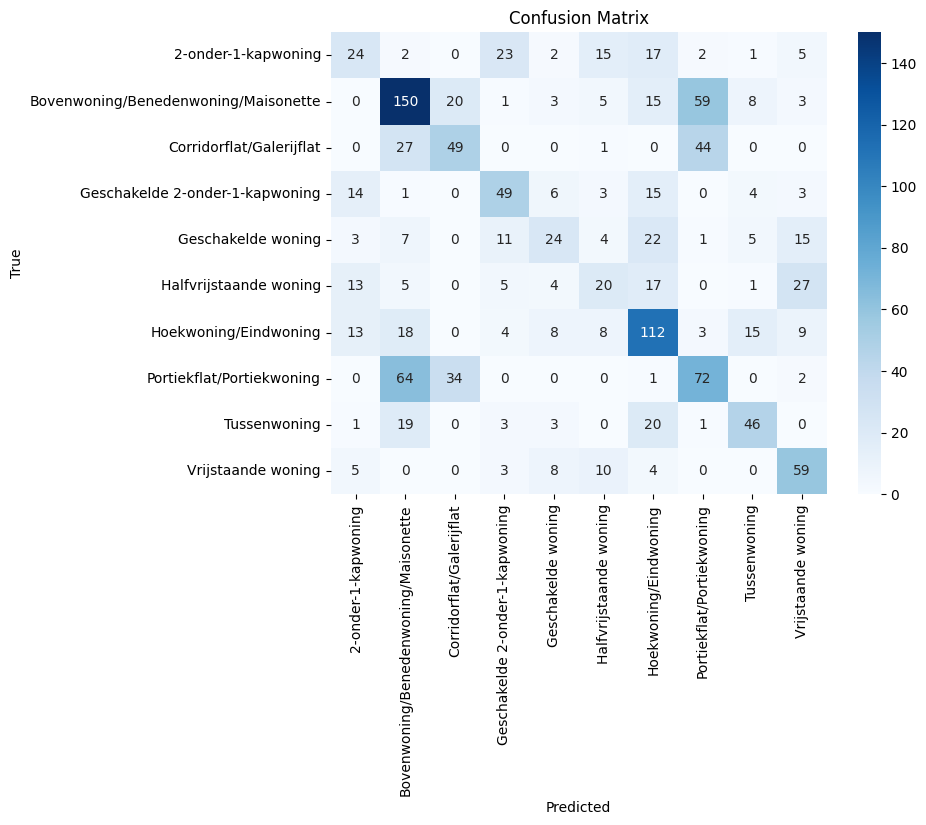

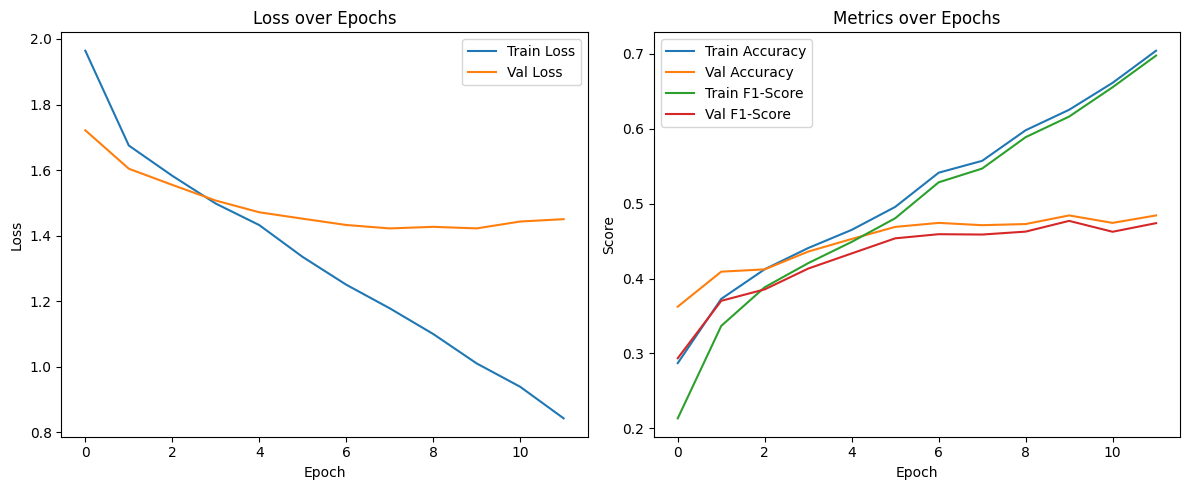


Final training and evaluation complete!


In [ ]:
# --- Section 9: Model training ---
print("\n" + "="*50)
print("Starting Supervised Fine-tuning Phase")
print("="*50 + "\n")

NUM_CLASSES = len(label_encoder.classes_)
class_names = label_encoder.classes_

if pretraining == False:
    model = ResNet50Classifier(num_classes=NUM_CLASSES).to(device)
    # Load backbone weights only (ignore classifier head)
    backbone_state = torch.load("models/resnet50_ssl_pretrained_backbone3.pth", map_location=device)
    missing, unexpected = model.base_model.load_state_dict(backbone_state, strict=False)
    print(f"Loaded backbone weights. Missing keys: {missing}, Unexpected keys: {unexpected}")
else:
    model = ResNet50Classifier(num_classes=NUM_CLASSES).to(device)
    backbone_state = torch.load(pretrained_weights_file, map_location=device)
    missing, unexpected = model.base_model.load_state_dict(backbone_state, strict=False)
    print(f"Loaded backbone weights. Missing keys: {missing}, Unexpected keys: {unexpected}")

# You can apply differential learning rates here if desired
# For now, a single optimizer for all trainable parameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4) # Smaller LR for fine-tuning
criterion = nn.CrossEntropyLoss()

best_val_f1 = -1.0
NUM_FINE_TUNE_EPOCHS_PHASE1 = 3 # Adjust epochs for actual training
NUM_FINE_TUNE_EPOCHS_PHASE2 = 9

history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
            'val_loss': [], 'val_acc': [], 'val_f1': []}

print(f"Fine-tuning head for {NUM_FINE_TUNE_EPOCHS_PHASE1} epochs...")
for epoch in range(NUM_FINE_TUNE_EPOCHS_PHASE1):
    print(f"\n--- Fine-tuning Epoch {epoch+1}/{NUM_FINE_TUNE_EPOCHS_PHASE1} ---")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Save best model based on validation F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "models/best_house_classifier.pth")
        print(f"Saved best model with Val F1: {best_val_f1:.4f}")

for param in model.base_model.layer4.parameters():
    param.requires_grad = True
for param in model.base_model.layer3.parameters():
    param.requires_grad = True

# Re-initialize optimizer for all trainable parameters with a lower learning rate
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)

print(f"Fine-tuning layer3 & 4 for {NUM_FINE_TUNE_EPOCHS_PHASE2} epochs...")
for epoch in range(NUM_FINE_TUNE_EPOCHS_PHASE2):
    print(f"\n--- Fine-tuning Epoch {epoch+1}/{NUM_FINE_TUNE_EPOCHS_PHASE2} ---")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)

    # Save best model based on validation F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), "models/best_house_classifier.pth")
        print(f"Saved best model with Val F1: {best_val_f1:.4f}")

print("\nFine-tuning complete!")

# Load the best model for final evaluation
model.load_state_dict(torch.load("models/best_house_classifier.pth", map_location=device))
print("\n" + "="*50)
print("Evaluating Best Model on Test Set")
print("="*50 + "\n")
evaluate_model(model, test_loader, device, class_names)

# Plotting training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Val Accuracy')
plt.plot(history['train_f1'], label='Train F1-Score')
plt.plot(history['val_f1'], label='Val F1-Score')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

print("\nFinal training and evaluation complete!")